In [2]:
import os
import sys
module_path = os.path.abspath(os.path.join('../'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
os.environ['CUDA_VISIBLE_DEVICES']='1'
    
import pandas as pd
from tqdm import tqdm

In [3]:
import matplotlib.pyplot as plt
import matplotlib

import torch
import torch.optim as optim
import numpy as np

%matplotlib inline
%load_ext autoreload
%autoreload 2

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Loading the tensors

In [3]:
data = torch.load('ADNI_t1', map_location='cpu')

In [4]:
print(f"There are {data['data'].shape[0]} visits with a total of {data['data'].shape[1]*data['data'].shape[2]*data['data'].shape[3]} dimentions")

There are 10047 visits with a total of 614400 dimentions


In [5]:
template_data_path = "/network/lustre/iss02/aramis/datasets/adni/caps/caps_v2021/subjects/sub-ADNI002S0295/ses-M00/deeplearning_prepare_data/image_based/t1_linear/sub-ADNI002S0295_ses-M00_T1w_space-MNI152NLin2009cSym_desc-Crop_res-1x1x1_T1w.pt"
template_data = torch.load(template_data_path)
#template_data = template_data[:,::2,::2,::2]

In [6]:
template_data = template_data[:,4:164:2,8:200:2,8:168:2]
template_data /= template_data.max()
template_data.shape

torch.Size([1, 80, 96, 80])

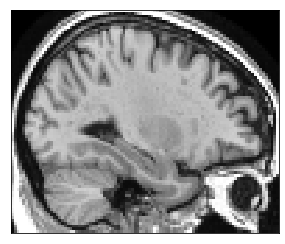

In [7]:
plt.matshow(np.rot90(data['data'][8][55]), cmap='Greys_r')
plt.xticks([])
plt.yticks([])
plt.show()

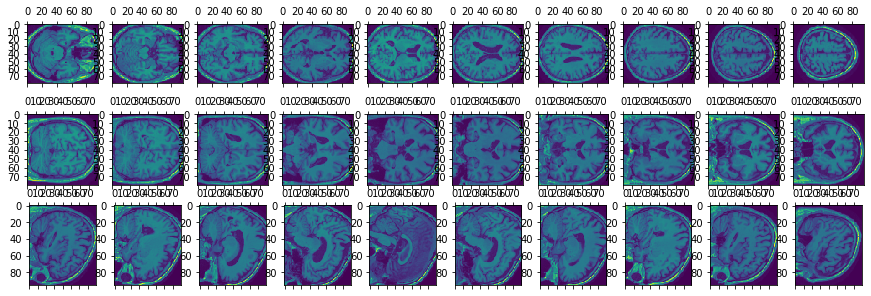

In [8]:
fig, axes = plt.subplots(3,10, figsize=(15,5))


for i in range(10):
    axes[0][i].matshow(template_data[0][:,:,20 + 5*i])
    axes[1][i].matshow(template_data[0][:,20 + 5*i])
    axes[2][i].matshow(template_data[0][20 + 5*i])

#plt.matshow(template_data[0][:,:,40])
plt.show()

In [4]:
caps_info = pd.read_csv('/network/lustre/iss02/aramis/datasets/adni/caps/caps_v2021.tsv', sep='\t', 
                        error_bad_lines=False)[['participant_id', 'session_id', 'age', 'diagnosis', 'MMSE', 'sex', 'apoe4', 'adas13']].set_index(['participant_id','session_id'])

caps_info

/home/benoit.sautydechalon/anaconda3/envs/deformetrica/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (117,118,119,310) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


age diagnosis  MMSE sex  apoe4  adas13
participant_id   session_id                                         
sub-ADNI002S0295 ses-M00     84.8        CN  28.0   M    1.0    4.00
                 ses-M06     85.3        CN  28.0   M    1.0    6.33
                 ses-M12     85.8        CN  30.0   M    1.0    5.67
                 ses-M24     87.0        CN  29.0   M    1.0    5.67
                 ses-M36     87.8        CN  28.0   M    1.0    6.67
...                           ...       ...   ...  ..    ...     ...
sub-ADNI941S6581 ses-M00     74.4        CN  30.0   F    0.0   11.33
                 ses-M12     75.4       NaN   NaN   F    0.0     NaN
                 ses-M24     76.4       NaN  30.0   F    0.0   15.33
sub-ADNI941S6803 ses-M00     75.0       MCI  28.0   F    NaN   32.67
sub-ADNI941S6854 ses-M00     86.2        AD  30.0   M    NaN   27.00

[16319 rows x 6 columns]

In [5]:
caps_info['ID'] = [int(sub[-4:]) for sub in caps_info.index.get_level_values(0)]
caps_info = caps_info.set_index('ID')
caps_info = caps_info.rename(columns={'age':'TIME','diagnosis':'diag'})
caps_info

,TIME,diag,MMSE,sex,apoe4,adas13
ID,,,,,,
295,84.8,CN,28.0,M,1.0,4.00
295,85.3,CN,28.0,M,1.0,6.33
295,85.8,CN,30.0,M,1.0,5.67
295,87.0,CN,29.0,M,1.0,5.67
295,87.8,CN,28.0,M,1.0,6.67
...,...,...,...,...,...,...
6581,74.4,CN,30.0,F,0.0,11.33
6581,75.4,NaN,NaN,F,0.0,NaN
6581,76.4,NaN,30.0,F,0.0,15.33


In [6]:
RIDs = [int(sub) for sub in list(data['RID'])]

df = pd.DataFrame(index=RIDs)
df.index.name = 'ID'
df['labels'] = data['labels']
df['TIME'] = data['timepoints']
df['img_idx'] = np.arange(len(df))
df['vent_true'] = None
df['vent_rec'] = None
df['hip_true'] = None
df['hip_rec'] = None

NameError: name 'data' is not defined

## Load the models

In [13]:
sys.path.append('/home/benoit.sautydechalon/deformetrica')
from deformetrica.core.model_tools.neural_networks.networks import CVAE_3D, VAE_GAN
from deformetrica.support.utilities.general_settings import Settings

import deformetrica as dfca
from deformetrica.core.models import LongitudinalAutoEncoder
from deformetrica.LAE_experiments.fit_longitudinal_auto_encoder import *
from deformetrica.support.utilities.general_settings import Settings

In [14]:
path_CAE = 'output_CVAE_16_MRI_15_big/CVAE_longitudinal'
path_model = 'model_MRI.xml'
path_data = 'ADNI_t1'

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
xml_parameters = dfca.io.XmlParameters()
xml_parameters._read_model_xml(path_model)
Settings().dimension = 16
Settings().number_of_sources = 15
Settings().device = device
deformetrica = dfca.Deformetrica(output_dir='output', verbosity=logger.level)

Logger has been set to: NOTSET


In [15]:
#torch_data = torch.load(path_data)
image_data = Dataset(data['data'].unsqueeze(1).float(), data['labels'], data['timepoints'])
number_of_subjects = len(np.unique(image_data.labels))

model, dataset, individual_RER = instantiate_longitudinal_auto_encoder_model(logger, path_data, path_CAE=path_CAE,
                                                                    number_of_subjects=number_of_subjects, xml_parameters=xml_parameters)

Loaded 9947 train images and 100 test images
>> Loaded CAE network from output_CVAE_16_MRI_15_big/CVAE_longitudinal
Model has a total of 11535009 parameters
>> Reading 15-source initial modulation matrix from file: output_CVAE_16_MRI_15_big/LongitudinalMetricModel_modulation_matrix.txt
Setting initial onset ages from output_CVAE_16_MRI_15_big/LongitudinalMetricModel_onset_ages.txt file
Setting initial log accelerations from output_CVAE_16_MRI_15_big/LongitudinalMetricModel_log_accelerations.txt file
Initialized the Euclidean metric for latent space
Setting the Euclidean exponential dimension to 16 from the settings
Setting the Euclidean exponential dimension to 16 from the settings
Setting the Euclidean exponential dimension to 16 from the settings
Setting initial sources from output_CVAE_16_MRI_15_big/LongitudinalMetricModel_sources.txt file
>> The time shift variance prior degrees of freedom parameter is set to 2250
>> The log-acceleration variance prior degrees of freedom parameter 

In [16]:
v0, p0, modulation_matrix = model._fixed_effects_to_torch_tensors(False)
onset_ages, log_accelerations, sources = model._individual_RER_to_torch_tensors(individual_RER, False)
t0 = model.get_reference_time()

absolute_times = model._compute_absolute_times(dataset.times, log_accelerations, onset_ages)

absolute_times_to_write = []

for elt in absolute_times:
    for e in elt.cpu().data.numpy():
        absolute_times_to_write.append(e)

model._update_spatiotemporal_reference_frame(absolute_times, p0, v0, modulation_matrix)
model.CAE.training = False

Tmin 35 Tmax 120 Update of the spatiotemporalframe: 5018 ms


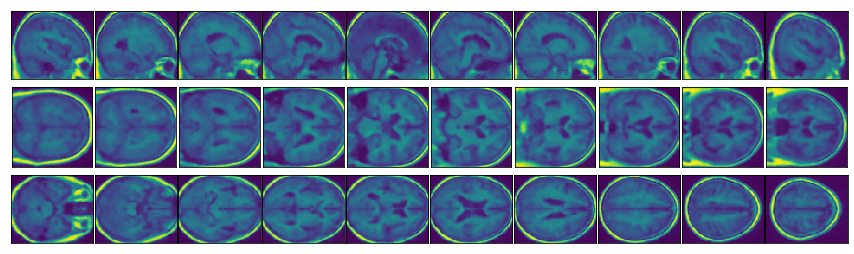

In [17]:
model.CAE.to(device)
_, _, reconstructed = model.CAE(torch.FloatTensor(template_data.unsqueeze(0)).to(device))
reconstructed = reconstructed.cpu().detach().numpy()[0]

fig, axes = plt.subplots(3,10, figsize=(15,4.5))
plt.subplots_adjust(wspace=0.02, hspace=0.02)

for i in range(10):
    axes[2][i].matshow(reconstructed[0][:,:,20 + 5*i])
    axes[1][i].matshow(reconstructed[0][:,20 + 5*i])
    axes[0][i].matshow(np.rot90(reconstructed[0][20 + 5*i]))

for axe in axes:
    for ax in axe:
        ax.set_xticks([])
        ax.set_yticks([])

#plt.matshow(template_data[0][:,:,40])
plt.show()

In [18]:
ip = pd.DataFrame(index=df.index.unique() ,columns=['onset_age','log_acceleration','s1','s2','s3','s4'])

ip['onset_age'] = individual_RER['onset_age']
ip['log_acceleration'] = individual_RER['log_acceleration']
for i in range(individual_RER['sources'].shape[1]):
    ip['s'+str(i)] = individual_RER['sources'][:,i]

## Loading the predictor network

In [ ]:
from deformetrica.core.model_tools.neural_networks.metric_networks import ffs

In [27]:
predictor = ffs()
predictor.load_state_dict(torch.load('../../core/model_tools/neural_networks/predictor'))

<All keys matched successfully>

In [78]:
model.CAE.training = False
model.CAE.to(device)
predictor.to(device)

df

for i in range(len(data['data'])):

    scan = data['data'][i].unsqueeze(0).unsqueeze(0).to(device)
    with torch.no_grad():
        reconstructed = model.CAE(scan)[2]
    
        a, b = predictor(scan)[0].cpu()
        c, d = predictor(reconstructed)[0].cpu()
    
    df['vent_true'].iloc[i] = float(a)
    df['vent_rec'].iloc[i] = float(c)
    df['hip_true'].iloc[i] = float(b)
    df['hip_rec'].iloc[i] = float(d)

/home/benoit.sautydechalon/anaconda3/envs/deformetrica/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [83]:
df['vent_diff'] = abs(df['vent_true'] - df['vent_rec'])
df['hip_diff'] = abs(df['hip_true'] - df['hip_rec'])
df

,labels,TIME,img_idx,vent_true,vent_rec,hip_true,hip_rec,vent_diff,hip_diff
ID,,,,,,,,,
295,0,84.8,0,0.474375,0.492931,0.755221,0.725599,0.018556,0.029622
295,0,85.3,1,0.503034,0.492323,0.760321,0.721621,0.010711,0.0387
295,0,85.8,2,0.498091,0.492414,0.757458,0.722487,0.005677,0.034971
295,0,87.0,3,0.501712,0.489628,0.74566,0.714856,0.012084,0.030804
295,0,87.8,4,0.490223,0.485244,0.730647,0.71951,0.004979,0.011137
...,...,...,...,...,...,...,...,...,...
6575,2246,74.5,10042,0.417716,0.471023,0.715148,0.737568,0.053307,0.022419
6580,2247,79.9,10043,0.259705,0.388064,0.639376,0.643548,0.128359,0.004171
6580,2247,80.9,10044,0.286672,0.4077,0.633774,0.647595,0.121028,0.013821


In [90]:
df.describe()

,labels,TIME,img_idx
count,10047.000000,10047.000000,10047.000000
mean,1088.106400,75.221210,5023.000000
std,630.920405,7.374879,2900.463411
min,0.000000,54.400000,0.000000
25%,560.000000,70.400000,2511.500000
50%,1070.000000,75.400000,5023.000000
75%,1652.000000,80.500000,7534.500000
max,2249.000000,97.300000,10046.000000


In [95]:
df.astype(float).describe()

,labels,TIME,img_idx,vent_true,vent_rec,hip_true,hip_rec,vent_diff,hip_diff
count,10047.000000,10047.000000,10047.000000,10047.000000,10047.000000,10047.000000,10047.000000,10047.000000,10047.000000
mean,1088.106400,75.221210,5023.000000,0.406875,0.426372,0.652851,0.671689,0.046927,0.054816
std,630.920405,7.374879,2900.463411,0.079776,0.050529,0.106850,0.063775,0.036167,0.047774
min,0.000000,54.400000,0.000000,0.036126,0.174681,0.017557,0.408055,0.000009,0.000010
25%,560.000000,70.400000,2511.500000,0.354186,0.392867,0.585833,0.631110,0.018887,0.020086
50%,1070.000000,75.400000,5023.000000,0.406899,0.426533,0.663467,0.677423,0.039003,0.042699
75%,1652.000000,80.500000,7534.500000,0.460390,0.460462,0.726896,0.718778,0.067081,0.075129
max,2249.000000,97.300000,10046.000000,0.942133,0.587322,0.968408,0.837783,0.365440,0.617525


array([[<AxesSubplot:title={'center':'TIME'}>,
        <AxesSubplot:title={'center':'vent_true'}>,
        <AxesSubplot:title={'center':'vent_rec'}>],
       [<AxesSubplot:title={'center':'hip_true'}>,
        <AxesSubplot:title={'center':'hip_rec'}>,
        <AxesSubplot:title={'center':'vent_diff'}>],
       [<AxesSubplot:title={'center':'hip_diff'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

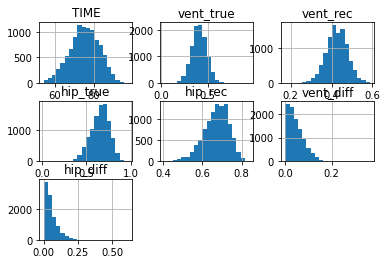

In [105]:
df.drop(['labels','img_idx'], axis=1).astype(float).hist(bins=20)

In [1]:
df

NameError: name 'df' is not defined